In [76]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, RandomSampler
from torchvision.models import ResNet50_Weights
from torchvision import datasets, transforms, models
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import random
import torchattacks

import warnings
warnings.filterwarnings(action='ignore') 

In [2]:
img_spec_real = './datasets/images/spectrogram/REAL/'
img_spec_fake = './datasets/images/spectrogram/FAKE/'
img_mfcc_real = './datasets/images/mfcc/REAL/'
img_mfcc_fake = './datasets/images/mfcc/FAKE/'

img_melspec = './datasets/images/spectrogram/'
img_mfcc = './datasets/images/mfcc'

mel_size = (200, 149)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [125]:
def dataLoader(dir, size) :
    transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
    ])

    full_dataset = datasets.ImageFolder(root=dir, transform=transform)

    # Train/Test set split
    real_indices = [i for i, (_, label) in enumerate(full_dataset) if label == 1]
    fake_indices = [i for i, (_, label) in enumerate(full_dataset) if label == 0]
    real_ratio = len(real_indices) / len(full_dataset)
    fake_ratio = len(fake_indices) / len(full_dataset)
    print('real vs fake :', len(real_indices), len(fake_indices), real_ratio, fake_ratio)

    train_size = 0.7
    val_size = 0.1
    test_size = 0.2

    train_real_size = int(train_size * len(real_indices))
    train_fake_size = int(train_size * len(fake_indices))
    val_real_size = int(val_size * len(real_indices))
    val_fake_size = int(val_size * len(fake_indices))

    random.shuffle(real_indices)
    random.shuffle(fake_indices)

    train_indices = real_indices[:train_real_size] + fake_indices[:train_fake_size]
    val_indices = real_indices[train_real_size:train_real_size+val_real_size] + fake_indices[train_fake_size:train_fake_size+val_fake_size]
    test_indices = real_indices[train_real_size+val_real_size:len(real_indices)] + fake_indices[train_fake_size+val_fake_size:len(fake_indices)]

    # fpr 계산을 위해 real(1) 값을 0으로, fake(0) 값을 1로 바꿔서 로드함
    train_dataset = [(data, 1 - label) for data, label in [full_dataset[i] for i in train_indices]]
    val_dataset = [(data, 1 - label) for data, label in [full_dataset[i] for i in val_indices]]
    test_dataset = [(data, 1 - label) for data, label in [full_dataset[i] for i in test_indices]]

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # 데이터셋 크기 확인
    print('Total:', len(full_dataset))
    print("Train dataset size:", len(train_dataset))
    print("Validation dataset size:", len(val_dataset))
    print("Test dataset size:", len(test_dataset))

    return train_loader, val_loader, test_loader, full_dataset

def getResnet50Training(train, val, num_epochs=5, learnigRate=0.001) :

    # ResNet-50 모델 로딩 및 수정
    resnet50 = models.resnet50(pretrained=True)
    # resnet50 = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
    resnet50.fc = nn.Linear(resnet50.fc.in_features, 2)  # 이진 분류 :출력 노드 개수 2개

    # 손실 함수, 옵티마이저 정의
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(resnet50.parameters(), lr=learnigRate)

    # GPU / CPU set
    resnet50.to(device)

    for epoch in range(num_epochs):
        resnet50.train()
        for inputs, labels in train:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = resnet50(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # 검증
        resnet50.eval()
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for inputs, labels in val:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = resnet50(inputs)
                _, preds = torch.max(outputs, 1)

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        # F1 Score 계산
        f1 = f1_score(all_labels, all_preds)
        accuracy = accuracy_score(all_labels, all_preds)
        print(f'Epoch {epoch+1}/{num_epochs}, Validation accuracy / f1 Score: {accuracy},{f1}')

    return resnet50

def getResnet50Test(model, test) :
    model.eval()
    all_preds_test = []
    all_labels_test = []

    with torch.no_grad():
        for inputs, labels in test:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds_test.extend(preds.cpu().numpy())
            all_labels_test.extend(labels.cpu().numpy())

    return all_labels_test, all_preds_test

def getEvalDf(label, pred) :
    cm = confusion_matrix(label, pred)
    tn, fp, fn, tp = cm.ravel()
    fpr = fp / (fp + tn) # 실제 정상을 악성으로 예측한 비율, 낮을 수록 좋음
    eval_df = pd.DataFrame({
        'accuracy' : [accuracy_score(label, pred)],
        'recall' : [recall_score(label, pred)],
        'precision' : [precision_score(label, pred)],
        'f1' : [f1_score(label, pred, average='weighted')],
        'rocauc' : [roc_auc_score(label, pred, average='weighted')],
        'fpr' : [fpr]
    })

    display(eval_df)
    print(cm)
    # print('[PRED]')
    # print(pd.Series(all_preds_test).value_counts())
    # print('[LABEL]')
    # print(pd.Series(all_labels_test).value_counts())


In [126]:
train_mel, val_mel, test_mel, full_dataset = dataLoader(img_melspec, mel_size) 
resnet50 = getResnet50Training(train_mel, val_mel, 10)

real vs fake : 381 2632 0.12645204115499503 0.873547958845005
Total: 3013
Train dataset size: 2108
Validation dataset size: 301
Test dataset size: 604
Epoch 1/10, Validation accuracy / f1 Score: 0.9601328903654485,0.9776119402985075
Epoch 2/10, Validation accuracy / f1 Score: 0.9534883720930233,0.9738805970149254
Epoch 3/10, Validation accuracy / f1 Score: 0.8903654485049833,0.9341317365269461
Epoch 4/10, Validation accuracy / f1 Score: 0.9534883720930233,0.9740740740740741
Epoch 5/10, Validation accuracy / f1 Score: 0.9667774086378738,0.9813432835820896
Epoch 6/10, Validation accuracy / f1 Score: 0.946843853820598,0.9693486590038315
Epoch 7/10, Validation accuracy / f1 Score: 0.9102990033222591,0.9511754068716094
Epoch 8/10, Validation accuracy / f1 Score: 0.8837209302325582,0.9290060851926978
Epoch 9/10, Validation accuracy / f1 Score: 0.9933554817275747,0.9961977186311787
Epoch 10/10, Validation accuracy / f1 Score: 0.9833887043189369,0.9905123339658444


In [127]:
all_labels_test, all_preds_test = getResnet50Test(resnet50, test_mel)
getEvalDf(all_labels_test, all_preds_test)

accuracy    recall  precision        f1    rocauc       fpr
0  0.988411  0.996205   0.990566  0.988312  0.965635  0.064935

[[ 72   5]
 [  2 525]]


### Adversarial examples, data augmentation
- FGSM (Fast Gradient Sign Method)
- CW

In [128]:
# FGSM
def fgsm_attack(model, images, labels, epsilon):
    images.requires_grad_(True)
    outputs = model(images)

    criterion  = nn.CrossEntropyLoss()
    loss = criterion(outputs, labels)
    model.zero_grad()
    loss.backward()

    gradient = images.grad.data
    perturbations = epsilon * torch.sign(gradient)
    adversarial_images = images + perturbations
    adversarial_images = torch.clamp(adversarial_images, 0, 1)

    return adversarial_images, perturbations

def test_with_fgsm(model, test, epsilon) :
    model.eval()
    all_fgsm_preds_test = []
    all_fgsm_labels_test = []
    adv_examples = []

    for inputs, labels in test:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        init_pred = outputs.max(1, keepdim=True)[1]
        # _, preds = torch.max(outputs, 1)

        fgsm_image, _ = fgsm_attack(model, inputs, labels, epsilon)

        fgsm_outputs = model(fgsm_image)
        _, fgsm_preds = torch.max(fgsm_outputs, 1)

        all_fgsm_preds_test.extend(fgsm_preds.cpu().numpy())
        all_fgsm_labels_test.extend(labels.cpu().numpy())

        if len(adv_examples) < 5:
            adv_ex = fgsm_image.squeeze().detach().cpu().numpy()
            adv_examples.append((init_pred, fgsm_preds, adv_ex))
    
    return all_fgsm_labels_test, all_fgsm_preds_test, adv_examples

In [129]:
epsilon_list = [0, 0.01, 0.05, 0.1, 0.15, 0.2]
accuracies = []
examples = []

for epsilon in epsilon_list :
    start = time.time()
    all_fgsm_labels_test, all_fgsm_preds_test, adv_examples = test_with_fgsm(resnet50, test_mel, epsilon)

    correct = sum(x == y for x, y in zip(all_fgsm_labels_test, all_fgsm_preds_test))
    final_acc = correct / float(len(test_mel.dataset))
    print(f"Epsilon: {epsilon}\tTime = {time.time() - start:.2f}\tTest Accuracy = {correct} / {len(test_mel.dataset)} = {final_acc}")


    accuracies.append(final_acc)
    examples.append(adv_examples)

Epsilon: 0	Time = 35.09	Test Accuracy = 597 / 604 = 0.9884105960264901
Epsilon: 0.01	Time = 32.00	Test Accuracy = 296 / 604 = 0.4900662251655629
Epsilon: 0.05	Time = 29.66	Test Accuracy = 475 / 604 = 0.7864238410596026
Epsilon: 0.1	Time = 32.32	Test Accuracy = 527 / 604 = 0.8725165562913907
Epsilon: 0.15	Time = 35.25	Test Accuracy = 527 / 604 = 0.8725165562913907
Epsilon: 0.2	Time = 35.64	Test Accuracy = 527 / 604 = 0.8725165562913907


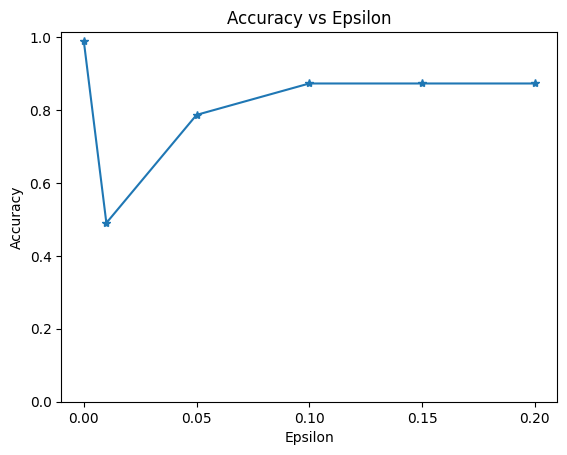

In [133]:
# plt.figure(figsize=(5,5))
plt.plot(epsilon_list, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.2))
plt.xticks(np.arange(0, .25, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.savefig('./result/fgsm_e_plot.png')
plt.show()

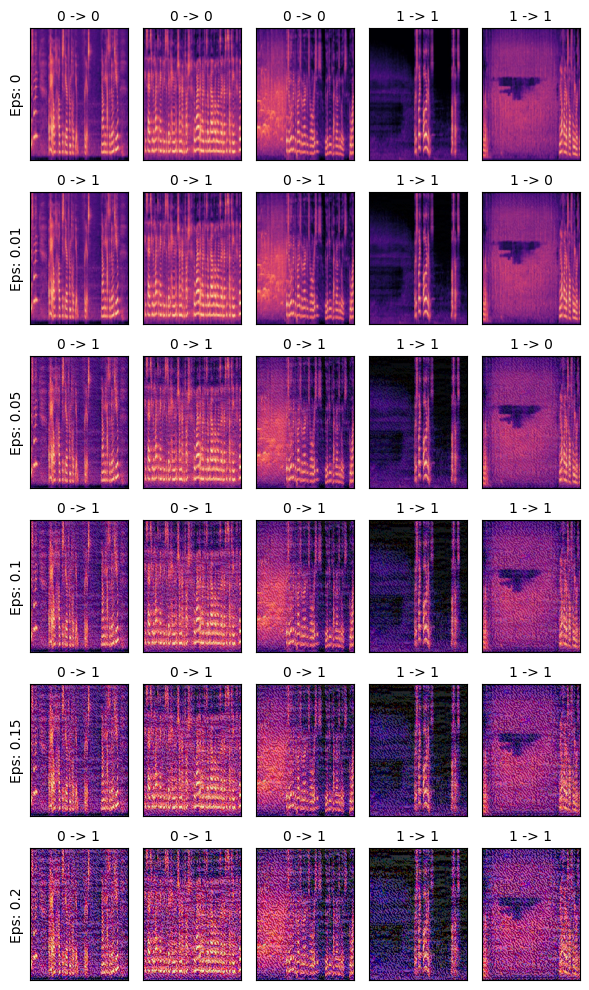

In [134]:
cnt = 0
plt.figure(figsize=(6, 10))
for i in range(len(epsilon_list)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilon_list),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel(f"Eps: {epsilon_list[i]}", fontsize=10)
        origin = examples[i][j][0][0].item()
        adv_pred = examples[i][j][1][0]
        ex = examples[i][j][2][0]
        # orig,adv,ex = examples[i][j]
        plt.title(f"{origin} -> {adv_pred}", fontsize=10)
        plt.imshow(ex.transpose(1,2,0))
plt.tight_layout()
plt.savefig('./result/fgsm_e.png')
plt.show()

#### CW Attack
###### Confidence(kappa) 
- 일반적으로 공격자가 원하는 성공확률을 셋팅
- confidence가 낮을 수록 적대적 예제는 모델이 높은 확신을 가지지 않은 상태에서도 원하는 타겟 클래스로 잘못 분류되도록 설계
- 값이 높으면 모델은 예측한 클래스에 대해 높은 신뢰를 갖게되어, 적대적 예제 생성이 더 어려워질 수 있음
- 0~1 사이의 값을 셋팅 (torchattacks default : 0)
- 만약 0.1로 설정시, 모델이 적대적 예제를 해당 클래스로 90% 이하의 확률로 예측할 것을 원하는 것, 따라서 모델이 예측한 클래스에 대한 확신이 낮아지므로 적대적 예제가 더 실제 데이터와 유사하게 만들어질 수 있음
###### Box-constraint(c) 
- 적대적 예제가 생성될 때 허용되는 입력값의 범위를 제한하는데 사용, 입력 특성의 min/max 값을 제한하여 적대적 예제가 현실적인 이미지와 유사하도록 만듬
- torchattacks default : 1

In [135]:
# CW Attack
# c : box-constraint, kappa : confidence
def test_with_cw(model, test, c=1.0, kappa=0.0) :
    model.eval()
    all_cw_preds_test = []
    all_cw_labels_test = []
    adv_examples = []

    for inputs, labels in test:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        init_pred = outputs.max(1, keepdim=True)[1]

        atk = torchattacks.CW(model, c=c, kappa=kappa)
        cw_image = atk(inputs, labels)
        cw_outputs = model(cw_image)
        _, cw_preds = torch.max(cw_outputs, 1)

        all_cw_preds_test.extend(cw_preds.cpu().numpy())
        all_cw_labels_test.extend(labels.cpu().numpy())

        if len(adv_examples) < 5:
            adv_ex = cw_image.squeeze().detach().cpu().numpy()
            adv_examples.append((init_pred, cw_preds, adv_ex))
    
    return all_cw_labels_test, all_cw_preds_test, adv_examples

In [136]:
kappa_list = [0.0, 0.2, 0.5, 0.7, 0.9]
c = 1.0
cw_accuracies = []
cw_examples = []

for kappa in kappa_list :
    start = time.time()
    all_cw_labels_test, all_cw_preds_test, adv_examples = test_with_cw(resnet50, test_mel, 1.0, kappa)

    correct = sum(x == y for x, y in zip(all_cw_labels_test, all_cw_preds_test))
    final_acc = correct / float(len(test_mel.dataset))
    print(f"Confidence: {kappa}\tBox-constraint: {c}\tTime = {time.time() - start:.2f}\tTest Accuracy = {correct} / {len(test_mel.dataset)} = {final_acc}")

    cw_accuracies.append(final_acc)
    cw_examples.append(adv_examples)

Confidence: 0.0	Box-constraint: 1.0	Time = 927.87	Test Accuracy = 11 / 604 = 0.018211920529801324
Confidence: 0.2	Box-constraint: 1.0	Time = 920.77	Test Accuracy = 13 / 604 = 0.02152317880794702
Confidence: 0.5	Box-constraint: 1.0	Time = 935.11	Test Accuracy = 13 / 604 = 0.02152317880794702
Confidence: 0.7	Box-constraint: 1.0	Time = 973.30	Test Accuracy = 12 / 604 = 0.019867549668874173
Confidence: 0.9	Box-constraint: 1.0	Time = 882.26	Test Accuracy = 13 / 604 = 0.02152317880794702


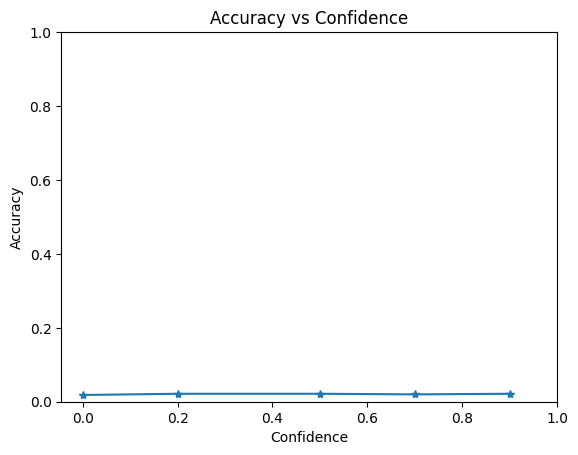

In [137]:
plt.plot(kappa_list, cw_accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.2))
plt.xticks(np.arange(0, 1.1, step=0.2))
plt.title("Accuracy vs Confidence")
plt.xlabel("Confidence")
plt.ylabel("Accuracy")
plt.savefig('./result/cw_confidence_plot.png')
plt.show()

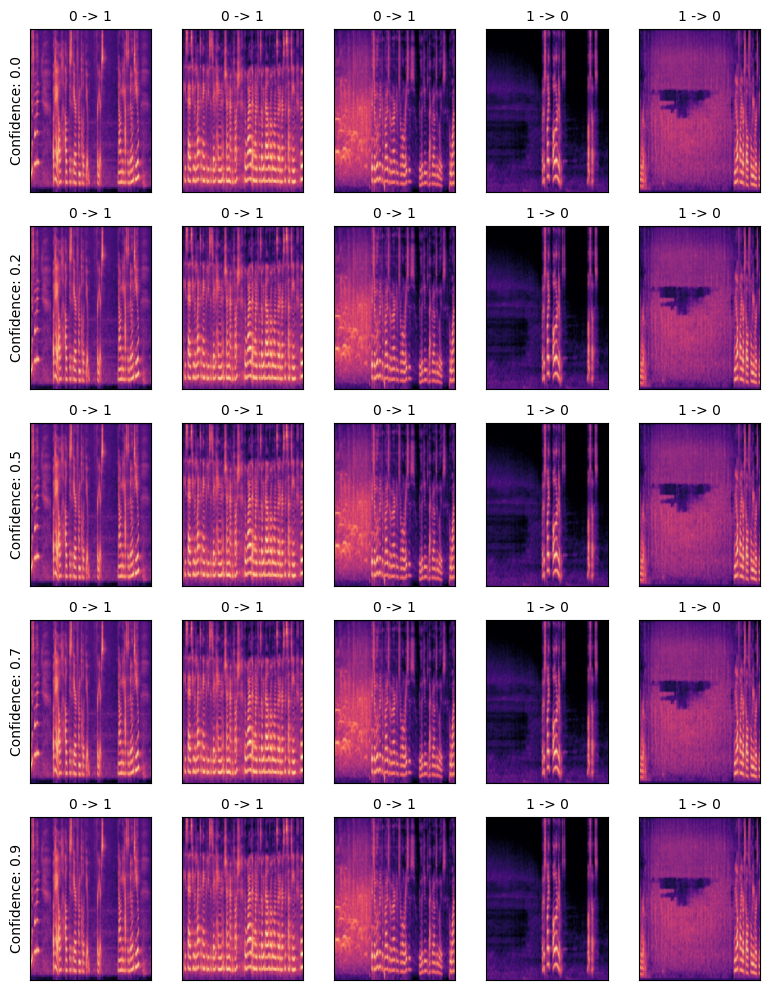

In [138]:
cnt = 0
plt.figure(figsize=(8, 10))
for i in range(len(kappa_list)):
    for j in range(len(cw_examples[i])):
        cnt += 1
        plt.subplot(len(kappa_list),len(cw_examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel(f"Confidence: {kappa_list[i]}", fontsize=10)
        origin = cw_examples[i][j][0][0].item()
        adv_pred = cw_examples[i][j][1][0]
        ex = cw_examples[i][j][2][0]
        # orig,adv,ex = examples[i][j]
        plt.title(f"{origin} -> {adv_pred}", fontsize=10)
        plt.imshow(ex.transpose(1,2,0))
plt.tight_layout()
plt.savefig('./result/cw_confidence.png')
plt.show()

In [139]:
kappa = 0.0
c_list = [0.2, 0.5, 0.9, 1.0, 1.1, 1.5, 2]
cw_c_accuracies = []
cw_c_examples = []

for c in c_list :
    start = time.time()
    all_cw_c_labels_test, all_cw_c_preds_test, adv_c_examples = test_with_cw(resnet50, test_mel, c, kappa)

    correct_c = sum(x == y for x, y in zip(all_cw_c_labels_test, all_cw_c_preds_test))
    final_c_acc = correct_c / float(len(test_mel.dataset))
    print(f"Confidence: {kappa}\tBox-constraint: {c}\tTime = {time.time() - start:.2f}\tTest Accuracy = {correct_c} / {len(test_mel.dataset)} = {final_c_acc}")

    cw_c_accuracies.append(final_c_acc)
    cw_c_examples.append(adv_c_examples)

Confidence: 0.0	Box-constraint: 0.2	Time = 905.75	Test Accuracy = 218 / 604 = 0.3609271523178808
Confidence: 0.0	Box-constraint: 0.5	Time = 763.80	Test Accuracy = 57 / 604 = 0.09437086092715231
Confidence: 0.0	Box-constraint: 0.9	Time = 815.43	Test Accuracy = 15 / 604 = 0.024834437086092714
Confidence: 0.0	Box-constraint: 1.0	Time = 965.16	Test Accuracy = 13 / 604 = 0.02152317880794702
Confidence: 0.0	Box-constraint: 1.1	Time = 835.37	Test Accuracy = 9 / 604 = 0.014900662251655629
Confidence: 0.0	Box-constraint: 1.5	Time = 856.98	Test Accuracy = 6 / 604 = 0.009933774834437087
Confidence: 0.0	Box-constraint: 2	Time = 867.93	Test Accuracy = 1 / 604 = 0.0016556291390728477


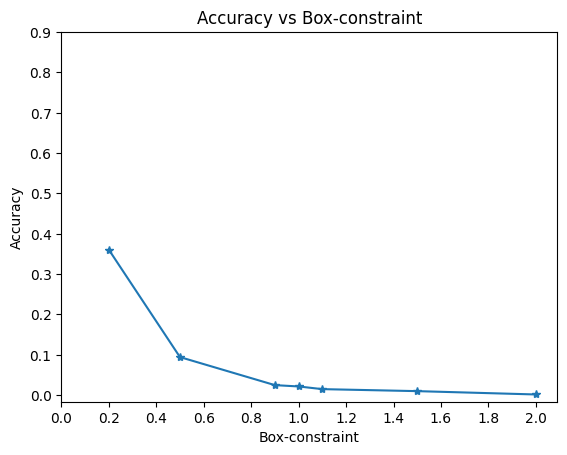

In [140]:
plt.plot(c_list, cw_c_accuracies, "*-")
plt.yticks(np.arange(0, 1, step=0.1))
plt.xticks(np.arange(0.0, 2.1, step=0.2))
plt.title("Accuracy vs Box-constraint")
plt.xlabel("Box-constraint")
plt.ylabel("Accuracy")
plt.savefig('./result/cw_box_c_plot.png')
plt.show()

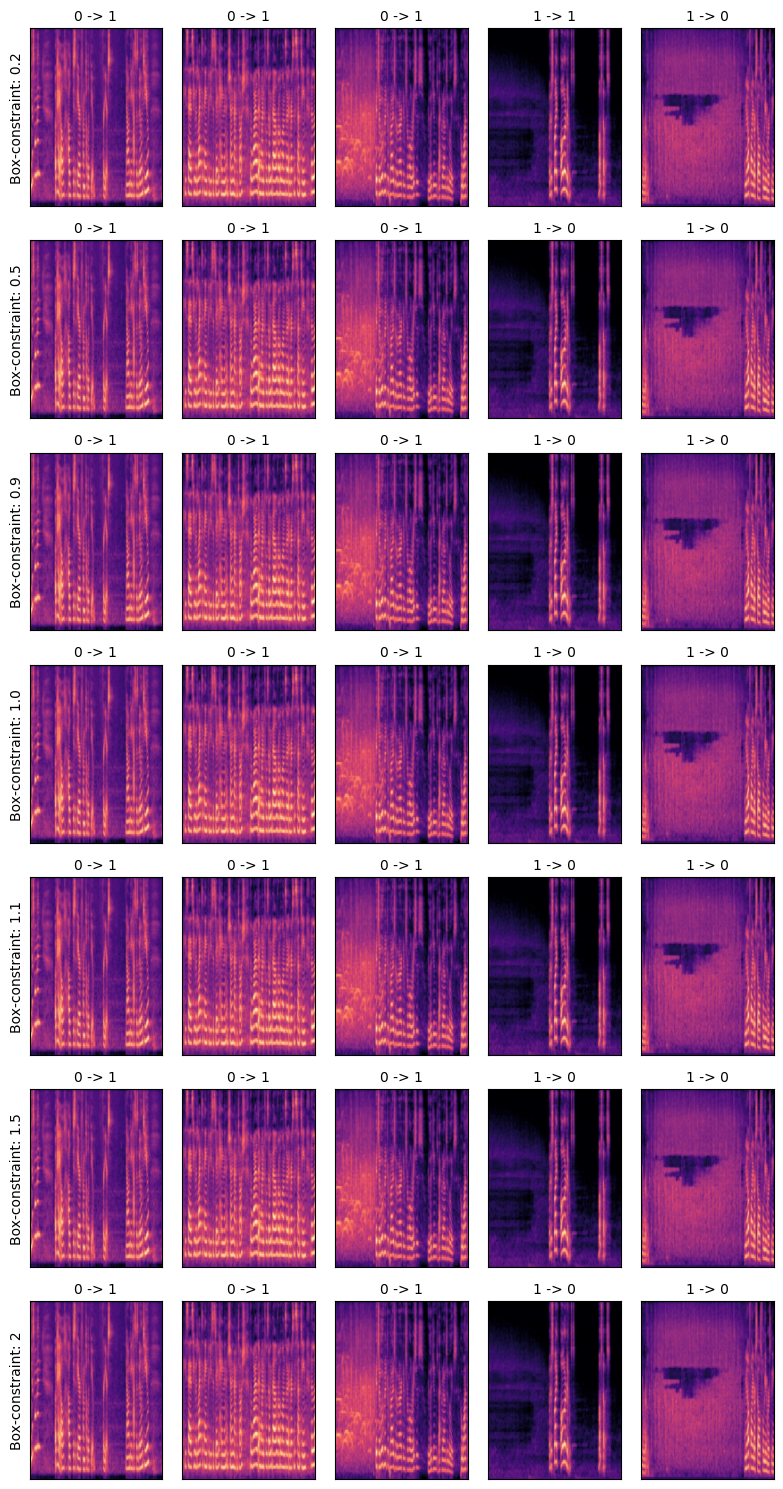

In [141]:
cnt = 0
plt.figure(figsize=(8, 15))
for i in range(len(c_list)):
    for j in range(len(cw_c_examples[i])):
        cnt += 1
        plt.subplot(len(c_list),len(cw_c_examples[0]), cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel(f"Box-constraint: {c_list[i]}", fontsize=10)
        origin = cw_c_examples[i][j][0][0].item()
        adv_pred = cw_c_examples[i][j][1][0]
        ex = cw_c_examples[i][j][2][0]
        # orig,adv,ex = examples[i][j]
        plt.title(f"{origin} -> {adv_pred}", fontsize=10)
        plt.imshow(ex.transpose(1,2,0))
plt.tight_layout()
plt.savefig('./result/cw_box_c.png')
plt.show()